In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [148]:
import sys
sys.path.append('../scripts')
import data_cleaning as cd

In [149]:
### Import data sources ###

# Training data
train = pd.read_csv('../data/train.csv')

#Previously purchased subscriptions by account
subscriptions = pd.read_csv('../data/subscriptions.csv')
#display(subscriptions.head())

# Location info for each patron and donation history
accounts = pd.read_csv('../data/account.csv')
#display(accounts.head())

# Previous concerts by season
concerts = pd.read_csv('../data/concerts.csv')
#display(concerts.head())

# List of planned concert sets for the 2014-15 season
planned_concerts = pd.read_csv('../data/concerts_2014-15.csv')
#display(planned_concerts.head())

# Previously purchased tickets by account
tickets = pd.read_csv('../data/tickets_all.csv')
#display(tickets.head())

# Location and demographic information for zipcodes
zipcodes = pd.read_csv('../data/zipcodes.csv')
#display(zipcodes.head())

# Final test data
final_test = pd.read_csv('../data/test.csv')

In [150]:
subscriptions, accounts, concerts, planned_concerts, tickets, zipcodes = cd.clean_data(subscriptions, accounts, concerts, planned_concerts, tickets, zipcodes)

Missing subscriptions data:  account.id              0
season                  0
package                 6
no.seats                0
location                6
section              4543
price.level          3534
subscription_tier       0
multiple.subs           0
dtype: int64 out of 28627 

Dropping rows with missing data...
Initial length of subscriptions:  28627
Length of subscriptions after cleaning:  24083
Encoding subscriptions categorical columns...
Missing accounts data:  account.id                     0
shipping.zip.code          19569
billing.zip.code            2955
shipping.city              19561
billing.city                2218
relationship               19172
amount.donated.2013            0
amount.donated.lifetime        0
no.donations.lifetime          0
first.donated              14298
dtype: int64 out of 19833 

Dropping rows with missing data...
Initial length of accounts:  19833
Length of accounts after cleaning:  5299
Missing concerts data:  season          0
concer

/Users/jc/code/kaggle/philarmoniab-kaggle/notebooks/../scripts/data_cleaning.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscriptions['section'] = subscriptions['section'].map(sections_map)
/Users/jc/code/kaggle/philarmoniab-kaggle/notebooks/../scripts/data_cleaning.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  accounts['first.donated'] = pd.to_datetime(accounts['first.donated'])
/Users/jc/code/kaggle/philarmoniab-kaggle/notebooks/../scripts/data_cleaning.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [151]:
print("Training set:")
# check how many account_id from training data are present in the other data sources
print("Subscriptions account ids: ")
display(pd.Series(train['account.id'].unique()).isin(subscriptions['account.id']).value_counts())

print("Accounts account ids: ")
display(pd.Series(train['account.id'].unique()).isin(accounts['account.id']).value_counts())

print("Tickets account ids: ")
display(pd.Series(train['account.id'].unique()).isin(tickets['account.id']).value_counts())

print("\nTest set:")
# check how many account_id from test data are present in the other data sources
print("Subscriptions account ids: ")
display(pd.Series(final_test['ID'].unique()).isin(subscriptions['account.id']).value_counts())

print("Accounts account ids: ")
display(pd.Series(final_test['ID'].unique()).isin(accounts['account.id']).value_counts())

print("Tickets account ids: ")
display(pd.Series(final_test['ID'].unique()).isin(tickets['account.id']).value_counts())

Training set:
Subscriptions account ids: 


False    4868
True     2073
Name: count, dtype: int64

Accounts account ids: 


False    5085
True     1856
Name: count, dtype: int64

Tickets account ids: 


False    6214
True      727
Name: count, dtype: int64


Test set:
Subscriptions account ids: 


False    2093
True      882
Name: count, dtype: int64

Accounts account ids: 


False    2164
True      811
Name: count, dtype: int64

Tickets account ids: 


False    2683
True      292
Name: count, dtype: int64

In [152]:
def add_features(X):
    if 'ID' not in X.columns:
        X['ID'] = X['account.id']

    #########################
    # Subscription features #
    #########################
    subs_by_acc = subscriptions.groupby(['account.id'])
    subscriptions_by_account = pd.DataFrame({'num_subscriptions':subs_by_acc.size(), 
                                             'avg_seats_by_subscription': subs_by_acc['no.seats'].mean(),
                                            'sub_tier': subs_by_acc['subscription_tier'].apply(lambda x: x.mode().iloc[0]),
                                            'sub_seasons': subs_by_acc['season'].unique()
                                            }).reset_index()
    
    # Add total subscriptions by account id (if can't find, then 0)
    #X['num_subscriptions'] = X['ID'].map(subscriptions_by_account.set_index('account.id')['num_subscriptions'])
    # Assuming that if account doesn't appear on subscriptions data, then they have no subscriptions
    #X['num_subscriptions'] = X['num_subscriptions'].fillna(0)

    # Add average number of seats by subscription by account id (if can't find, then mean)
    X['avg_seats_by_subscription'] = X['ID'].map(subscriptions_by_account.set_index('account.id')['avg_seats_by_subscription'])
    X['avg_seats_by_subscription'] = X['avg_seats_by_subscription'].fillna(subscriptions_by_account['avg_seats_by_subscription'].mean())

    # Add average subscription price level by account id (if can't find, then mean)
    X['avg_subscription_price_level'] = X['ID'].map(subscriptions.groupby(['account.id'])['price.level'].mean())
    X['avg_subscription_price_level'] = X['avg_subscription_price_level'].fillna(subscriptions['price.level'].mean())
    # Add average subscription tier by account id (if can't find, then mean)
    X['avg_subscription_tier'] = X['ID'].map(subscriptions.groupby(['account.id'])['subscription_tier'].mean())
    X['avg_subscription_tier'] = X['avg_subscription_tier'].fillna(subscriptions['subscription_tier'].mean())

    # Let's create an aggregate feature that gives an estimate of how much the account spent on subscriptions
    # this value takes into consideration not only the amount of subscriptions but multiplies it by the price level of the subscription
    X['total_spent_in_subscriptions'] = X['ID'].map(subscriptions.groupby(['account.id'])['price.level'].sum())
    X['total_spent_in_subscriptions'] = X['total_spent_in_subscriptions'].fillna(0)

    # Add average value for section by account id (if can't find, then mean)
    X['avg_section_value'] = X['ID'].map(subscriptions.groupby(['account.id'])['section'].mean())
    X['avg_section_value'] = X['avg_section_value'].fillna(subscriptions['section'].mean())

    ###################
    # Ticket features #
    ###################
    tickets_by_account = pd.DataFrame({'num_tickets':tickets.groupby(['account.id']).size()}).reset_index()
    # Add total tickets by account id (if can't find, then 0)
    X['num_tickets'] = X['ID'].map(tickets_by_account.set_index('account.id')['num_tickets'])
    # Assuming that if account doesn't appear on tickets data, then they have no tickets
    X['num_tickets'] = X['num_tickets'].fillna(0)

    # Add total tickets just for the 2013-2014 season by account id (if can't find, then 0)
    X['num_tickets_2013'] = X['ID'].map(tickets[tickets['season'] == '2013-2014'].groupby(['account.id'])['no.seats'].sum())
    X['num_tickets_2013'] = X['num_tickets_2013'].fillna(0)

    # Add average ticket price level by account id (if can't find, then mean)
    X['avg_ticket_price_level'] = X['ID'].map(tickets.groupby(['account.id'])['price.level'].mean())
    X['avg_ticket_price_level'] = X['avg_ticket_price_level'].fillna(tickets['price.level'].mean())

    # Add total number of seats by account id (if can't find, then 0)
    X['num_seats'] = X['ID'].map(tickets.groupby(['account.id'])['no.seats'].sum())
    X['num_seats'] = X['num_seats'].fillna(0)

    # Add total number of seats just for the 2013-2014 season by account id (if can't find, then 0)
    X['num_seats_2013'] = X['ID'].map(tickets[tickets['season'] == '2013-2014'].groupby(['account.id'])['no.seats'].sum())
    X['num_seats_2013'] = X['num_seats_2013'].fillna(0)

    #####################
    # Concerts features #
    #####################
    # group concerts by season and aggregate list of unique conductors
    concerts['conductor'] = concerts['who'].apply(lambda x: x.split(',')[0])
    conductors_by_season = concerts.groupby(['season'])['conductor'].unique().reset_index()

    # create new column conductors in subscriptions_by_account with all the unique values as a flattened list from conductors_by_season where the season is one of the sub_seasons
    subscriptions_by_account['conductors'] = subscriptions_by_account['sub_seasons'].apply(lambda x: set([item for sublist in conductors_by_season[conductors_by_season['season'].isin(x)]['conductor'] for item in sublist]))

    # transform "who" column in planned_concerts to "conductors" column with just the name of the conductors
    planned_concerts['conductors'] = planned_concerts['who'].apply(lambda x: x.split(',')[0])
    #display(planned_concerts.head())
    # aggregate list of unique conductors in next season
    planned_conductors = planned_concerts['conductors'].unique()
    subscriptions_by_account['watched_conductors'] = subscriptions_by_account['conductors'].apply(lambda x: len(x.intersection(planned_conductors)))
    #display(planned_conductors)
    #display(conductors_by_season)           
    #display(subscriptions_by_account.iloc[0]['conductors'])
    #display(subscriptions_by_account['watched_conductors'].value_counts())
    #display(subscriptions_by_account[subscriptions_by_account['conductors'].apply(lambda x: len(x)) == 8])
    subscriptions_by_account.drop(['sub_seasons', 'conductors'], axis=1, inplace=True)


    X['watched_conductors'] = X['ID'].map(subscriptions_by_account.set_index('account.id')['watched_conductors'])
    X['watched_conductors'] = X['watched_conductors'].fillna(0)

    ####################
    # Account features #
    ####################

    # Add total number of donations by account id (if can't find, then 0)
    # Find account by id on accounts dataframe and get the value of no.donations.lifetime column
    #X['num_donations'] = X['ID'].map(accounts.groupby(['account.id'])['no.donations.lifetime'].sum())
    # Assuming that if account doesn't appear on accounts data, then they have no donations
    #X['num_donations'] = X['num_donations'].fillna(0)

    # Add total amount of donations by account id (if can't find, then 0)
    X['total_donated'] = X['ID'].map(accounts.groupby(['account.id'])['amount.donated.lifetime'].sum())
    # Assuming that if account doesn't appear on accounts data, then they have no donations
    X['total_donated'] = X['total_donated'].fillna(0)

    # merge X and accounts on ID and account.id respectively
    mdf = pd.merge(X, accounts, left_on='ID', right_on='account.id', how='left')
    mdf = mdf.merge(zipcodes, left_on='billing.zip.code', right_on='Zipcode', how='left')[['ID', 'TotalWages']]
    
    # Add total wages by account zip code (if can't find, then 0)
    X['total_local_wage'] = X['ID'].map(mdf.groupby(['ID'])['TotalWages'].sum())
    X['total_local_wage'] = X['total_local_wage'].fillna(zipcodes['TotalWages'].mean())

    return X

In [153]:
def train_lr(X_train_scaled, y_train, X_val_scaled, y_val):
    acc_scores = []
    c_vals = np.arange(0.1,5,0.1)
    for c in c_vals:
        model = LogisticRegression(penalty='l2',C=c)
        scores = cross_val_score(model,X_train_scaled,y_train,scoring='accuracy',cv=5)
        acc_scores.append(np.mean(scores))

    plt.plot(c_vals,acc_scores)
    opt_c = c_vals[np.argmax(acc_scores)]
    plt.title('Optimal penalty C is {:.3f}'.format(opt_c))
    plt.xlabel('C (1/lambda)')
    plt.ylabel('Cross-validated accuracy score')
    plt.show()


    # Retrain the final model on the full training set and calculate the test set accuracy
    final_model = LogisticRegression(penalty='l2',C=opt_c,random_state=0)
    final_model.fit(X_train_scaled,y_train)
    val_preds = final_model.predict(X_val_scaled)
    acc_score = accuracy_score(y_val,val_preds)
    print('Accuracy on test set is {:.3f}'.format(acc_score))

    return final_model

In [154]:
def calc_feature_importances(model,feat_names,num_to_show):
    # Determine the relative importance of each feature using the random forest model
    importances = model.feature_importances_
    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:num_to_show][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()
    return RF_ranking

In [155]:
def train_random_forest(columns, X_train_scaled, y_train, X_val_scaled, y_val):
    params = {'min_samples_leaf':[1,3,10],'n_estimators':[100,1000],
          'max_features':[0.1,0.5,1.],'max_samples':[0.5,None]}

    #model = RandomForestClassifier()
    #grid_search = GridSearchCV(model,params,cv=3)
    #grid_search.fit(X_train_scaled,y_train)

    #bp = grid_search.best_params_

    #print(bp)

    #rf_model = RandomForestClassifier(criterion='gini',max_depth=None, min_samples_leaf=bp['min_samples_leaf'],n_estimators=bp['n_estimators'],
    #                             max_features=bp['max_features'],max_samples=bp['max_samples'])
   

    rf_model = RandomForestClassifier(criterion='gini',max_depth=None, min_samples_leaf=3,n_estimators=100,
                                 max_features=0.5,max_samples=0.5)

    rf_model.fit(X_train_scaled, y_train)

    top_feats = 30
    calc_feature_importances(rf_model,columns,top_feats)
    
    val_preds = rf_model.predict(X_val_scaled)
    print('Validation set accuracy is {:.3f}'.format(accuracy_score(y_val,val_preds)))
    print('Validation set AUROC is {:.3f}'.format(roc_auc_score(y_val,val_preds)))

    return rf_model
    

,Feat Index,Feature,Importance
0,10,watched_conductors,0.528699
1,1,avg_subscription_price_level,0.108974
2,3,total_spent_in_subscriptions,0.104771
3,11,total_donated,0.078979
4,12,total_local_wage,0.063988
5,4,avg_section_value,0.044066
6,2,avg_subscription_tier,0.026441
7,0,avg_seats_by_subscription,0.013709
8,5,num_tickets,0.009951
9,7,avg_ticket_price_level,0.008584


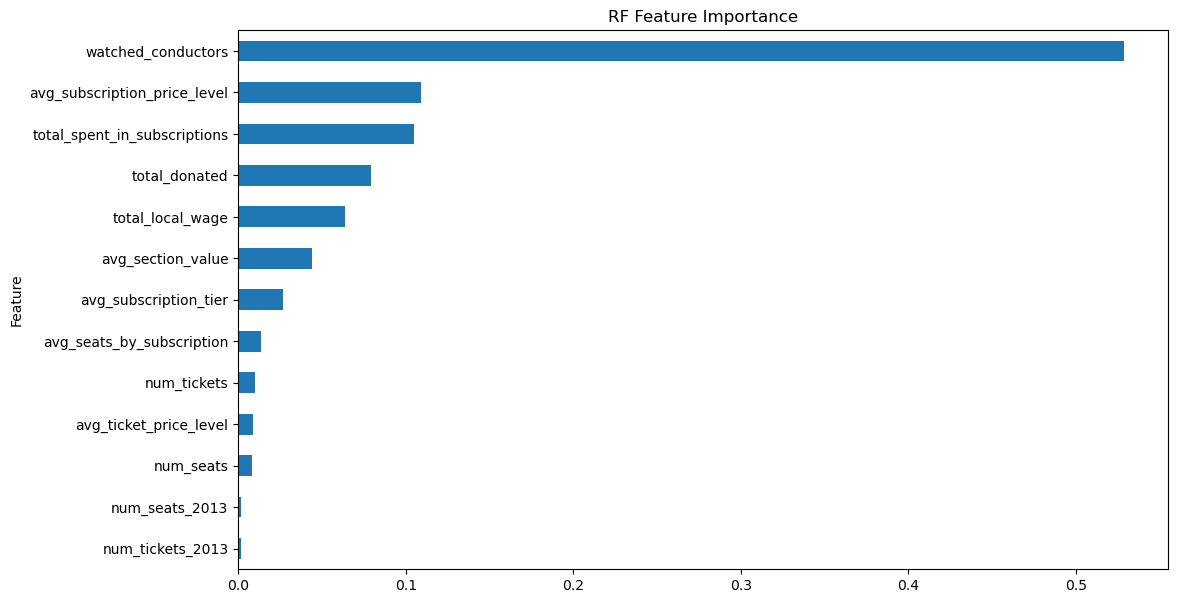

Validation set accuracy is 0.978
Validation set AUROC is 0.873
Accuracy on entire training set: 0.982
AUROC on entire training set: 0.882


In [156]:
X = train.copy()

X = add_features(X)

y = X['label']
X = X.drop(['account.id', 'ID', 'label'], axis=1)

X_train,X_val,y_train,y_val = train_test_split(X, y, random_state=0,test_size=0.2)

scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)

#model = train_random_forest(X.columns, X_train_scaled, y_train, X_val_scaled, y_val)
model = train_random_forest(X.columns, X_train, y_train, X_val, y_val)

model.fit(X,y)

preds = model.predict(X)
print('Accuracy on entire training set: {:.3f}'.format(accuracy_score(y,preds)))
print('AUROC on entire training set: {:.3f}'.format(roc_auc_score(y,preds)))

In [157]:
X_test = final_test.copy()

X_test = add_features(X_test)

X_test = X_test.drop(['ID'], axis=1)

preds = model.predict(X_test)

final_test['Predicted'] = preds

final_test[['ID', 'Predicted']].to_csv('../data/test_predictions.csv', index=False)

print("Submission file created!")

Submission file created!
